In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import bottleneck as bn


import os

import h5py

import obspy

from scipy import ndimage
from scipy import stats

%matplotlib inline

In [2]:
def loadtdms(file_path:str, first_channel:int=0,
             last_channel:int=None, first_time_sample:int=0, last_time_sample:int=29999, normalize:bool=True):
    '''
    The only parameter that needs to specified is filepath. i.e 
    data,props,distances = loadtdms(file_path)
    This can be  ignored if defaultTDMSfilePath is specified. i.e
    data,props,distances = loadtdms()
    Parameters
    ----------
    file_path : str, optional if defaultTDMSfilePath is specified
        path to the tdms file to be loaded
    first_channel : int, optional
        specify the start of the range of channels to get
    last_channel : int, optional
        specify the end of the range of channels to get.
    first_time_sample : int, optional
        specify the start of the range of time samples to get.
    last_time_sample : int, optional
        specify the end of the range of time samples to get.
    normalize : bool, optional
        if each channel of the data return should be normalized or not.

    Returns
    -------
    data : numpy array
        2 dimensional array containing the data. channels by samples
    props : dictionary
        Contains the attributes of the data loaded
    distances : numpy array
        contains a list of distances corresponding to each channel

    '''
    import tdms_reader as tr
    tdms = tr.TdmsReader(file_path)
    props = tdms.get_properties()
    zero_offset = props.get('Zero Offset (m)') 
    channel_spacing = props.get('SpatialResolution[m]') * props.get('Fibre Length Multiplier')
    n_channels = tdms.fileinfo['n_channels']
    distances = zero_offset + np.arange(n_channels) * channel_spacing

    data = tdms.get_data(first_channel, last_channel, first_time_sample, last_time_sample)
    data=data.transpose()
        
    if normalize:
        nSamples=last_time_sample-first_time_sample+1
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        
        max_of_rows = abs(data).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
        
    return data,props,distances

def loadBradyHShdf5(file_path:str, normalize:bool=True):
    '''

    Parameters
    ----------
    file_path : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file_path,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize:
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr

def load_nodal(file_path:str):
    '''
    Load nodal data from a SAC file
    
    Parameters
    ----------
    file_path : string
        path to the SAC file to be loaded
        
    Returns
    -------
    trace : obspy trace object
        trace object containing the data from the SAC file
    '''
    
    st = obspy.read(file_path, format='SAC')
    trace = st[0] 
    trace.detrend("demean"); trace.detrend("linear")
    return trace

In [16]:
def basicSeismicPlotter(data:np.ndarray, percentClip:int=5, filename:str=None, colormap:str='seismic', extent:list=None) -> None:
    '''
    Parameters
    ----------
    data : 2 dimensional numpy array
        DESCRIPTION.
    percentClip : int, optional
        The range of values for cmap will be +(100-percentClip) percentile to 
        -(100-percentClip) percentile. The default is 5.
    filename : str, file path, optional
        filename orPath to file to save image to. The default is None.
    colormap : str, optional
        Valid colormap from the allowed list of python colormaps. 
        The default is 'seismic'.

    Returns
    -------
    Plots image of the data and saves it to the specified file path if provided

    '''
    
    maxval = np.percentile(np.absolute(data),100.0-percentClip/2.0)
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap=plt.get_cmap(colormap), vmin=-maxval, vmax=maxval, extent=extent)
    plt.colorbar(label = 'Strain rate (1/s)')
    if filename is not None:
        plt.savefig(filename)
        plt.clf()
        
    return

def preprocess(data:np.ndarray) -> np.ndarray:
    
    # get rid of laser drift
    med = np.median(data,axis=0)
    data=data-med[np.newaxis,:]
    
    max_of_rows = abs(data).sum(axis=1)
    data = data/ (max_of_rows[:, np.newaxis])
    
    return data

def magspec(data:np.ndarray) -> np.ndarray:
    '''
    calculate the magnitude spectrum of a 1D array
    outputs the frequency and magnitude spectrum
    '''
    freqs = np.fft.fftfreq(data.size)
    spectrum = np.fft.rfft(data, norm='forward')
    
    return freqs, np.abs(spectrum)

In [4]:
def pearson(data:np.ndarray, buf:int=4) -> np.ndarray:
    '''
    Calculates the correlation coefficients using Pearson's correlation coefficient.
    data: numpy array of shape (n_channels, n_samples)
    buf: number of channels to use for correlation coefficient calculation
    '''
    
    # Compute correlation coefficients using vectorized Pearson's correlation coefficient function
    i_vals = np.arange(data.shape[0] - buf)
    j_vals = np.arange(1, buf)
    corr_coefs = np.array([stats.pearsonr(data[i, :], data[i+j, :])[0] for i in i_vals for j in j_vals])
    init_matrix = corr_coefs.reshape((data.shape[0] - buf, buf - 1))

    # Compute median of correlation coefficients for each channel and store in output array
    corr_matrix = np.median(init_matrix, axis=1)

    return corr_matrix

def spearman(data:np.ndarray, buf:int=4) -> np.ndarray:
    '''
    Calculates the correlation coefficients using Spearman's correlation coefficient.
    data: numpy array of shape (n_channels, n_samples)
    buf: number of channels to use for correlation coefficient calculation
    '''
    
    # Compute correlation coefficients using vectorized Pearson's correlation coefficient function
    i_vals = np.arange(data.shape[0] - buf)
    j_vals = np.arange(1, buf)
    corr_coefs = np.array([stats.spearmanr(data[i, :], data[i+j, :])[0] for i in i_vals for j in j_vals])
    init_matrix = corr_coefs.reshape((data.shape[0] - buf, buf - 1))

    # Compute median of correlation coefficients for each channel and store in output array
    corr_matrix = np.median(init_matrix, axis=1)

    return corr_matrix

def find_bad(corr:np.ndarray, thresh:float=None) -> np.ndarray:
    '''
    Find the indices of correlation coefficients where the value is less than the threshhold value as a numpy array
    corr: numpy array of correlation coefficients
    thresh: threshold value for "low" correlation coefficient. If None, the 5th percentile of the correlation coefficients is used
    '''
    
    if thresh == None:
        thresh = np.percentile(corr, 5)
    
    bad = np.array(np.where(corr < thresh))
    return bad, thresh

In [5]:
brady_path=r"data\PoroTomo_iDAS16043_160314001748.h5"
foresee_path = r'data\PSUDAS_UTC_20190415_033335.812.tdms'

In [7]:
node_number = 3
node_path = 'D:/Brady_Nodal/{:03d}'.format(node_number)
dir_list = os.listdir(node_path)
dir_list = sorted([os.path.join(node_path, filename) for filename in dir_list])

In [8]:
EHE = load_nodal(dir_list[0])
EHN = load_nodal(dir_list[1])
EHZ = load_nodal(dir_list[2])

tmin, tmax = 0, round(np.max(EHE.times()))

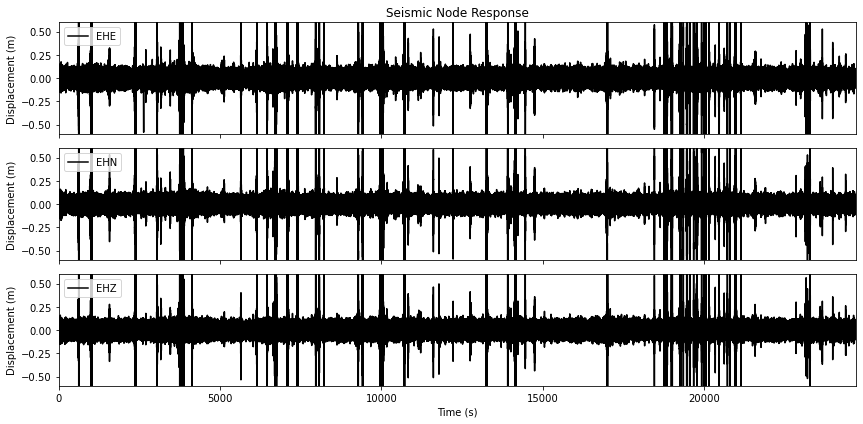

In [9]:
ymin, ymax = -0.6, 0.6

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].set_title("Seismic Node Response")
axes[0].plot(EHE.times(), EHE.data, "k", label="EHE")
axes[0].set_ylabel("Displacement (m)")
axes[0].legend(loc=2)
axes[0].set_ylim(ymin, ymax)

axes[1].plot(EHN.times(), EHN.data, "k", label="EHN")
axes[1].set_ylabel("Displacement (m)")
axes[1].legend(loc=2)
axes[1].set_ylim(ymin, ymax)

# axes[2].plot(EHN.times(), trace, "k", label=r"EHE$*$EHN")
axes[2].plot(EHZ.times(), EHZ.data, "k", label="EHZ")
axes[2].set_ylabel("Displacement (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend(loc=2)
axes[2].set_xlim(tmin, tmax)
axes[2].set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig('./fig/nodal_response.png')
plt.show()
plt.close('all')

In [10]:
# Silixa’s iDAS (TM) was used for DAS data acquisition with 1.021 m channel spacing and a guage length of 10 m.
# Horizontal DAS (DASH) data collection began 3/8/2016, paused, and then started again on 3/11/2016 and ended 3/26/2016 using zigzag trenched fiber optic cabels
brady_data, timestamps = loadBradyHShdf5(brady_path)
extent = [0, brady_data.shape[1]/1000, brady_data.shape[0], 0]
timestamps -= timestamps[0]

In [11]:
buf = 4
pearsonr = pearson(brady_data, buf)
# spearmanr = spearman(brady_data, buf)

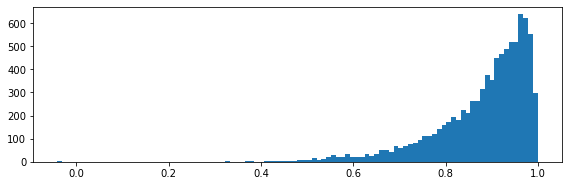

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(8,5))
plt.subplot(211)
plt.hist(pearsonr, bins=100)

# plt.subplot(212)
# plt.hist(spearmanr, bins=100)

plt.tight_layout()
plt.show()
plt.savefig(f"./fig/Brady_histogram.png")

In [13]:
bad, thresh = find_bad(pearsonr, 0.7)
only_good = np.delete(brady_data, bad, axis=1)
bad.size

598

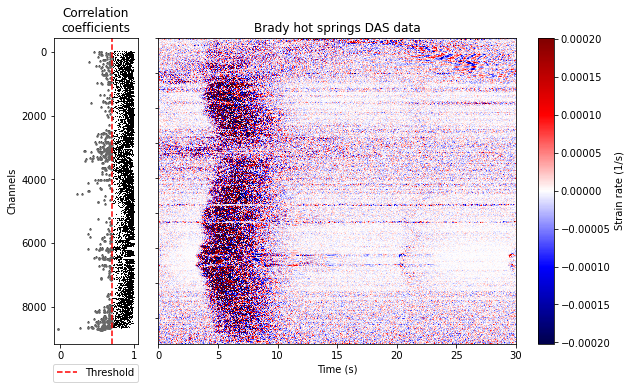

In [17]:
# play with line widths to get the best looking plot

fig = plt.figure(figsize=(9, 5.5))

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1.5, 8])

ax2 = fig.add_subplot(spec[0])
ax2.plot(pearsonr, np.arange(0, brady_data.shape[0]-buf), 'k,')
ax2.plot(pearsonr[bad], bad, color='dimgray', marker='.', markersize=3)
ax2.axvline(thresh, color='red', linestyle='dashed')
ax2.set_title("Correlation\ncoefficients")
ax2.set_ylabel("Channels")
plt.gca().invert_yaxis()

ax = fig.add_subplot(spec[1])
basicSeismicPlotter(brady_data, extent=extent)
ax.set_yticklabels([])
ax.set_xlabel("Time (s)")
ax.set_title("Brady hot springs DAS data")

ax2.legend(handles=[Line2D([0], [0], color='red', linestyle='--', label='Threshold')],
          loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True)

plt.tight_layout()
plt.savefig("./fig/correlation_subplot.png")
plt.show()
plt.close('all')

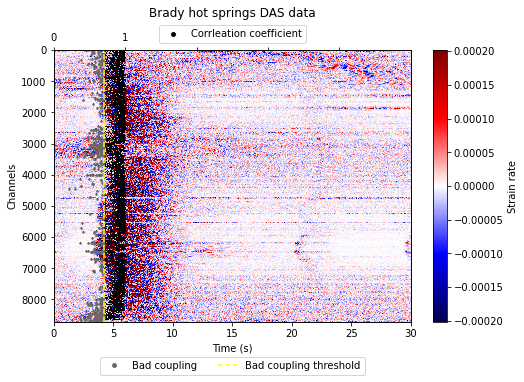

In [11]:
# play with line widths to get the best looking plot

fig, ax = plt.subplots(figsize=(8, 5))

basicSeismicPlotter(brady_data, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title("Brady hot springs DAS data", y=1.1)

ax2 = ax.twiny()
ax2.plot(pearsonr, np.arange(0, brady_data.shape[0]-buf), 'k,')
ax2.plot(pearsonr[bad], bad, color='dimgray', marker='.', markersize=3)
ax2.axvline(thresh, color='yellow', linestyle='dashed')

ax2.set_xlim([0,5])
ax2.set_xticks(np.arange(0,5), [0, 1, '', '', ''])

ax.legend(handles=[Line2D([0], [0], color='w', markerfacecolor='dimgray', marker='o', label='Bad coupling'),
                   Line2D([0], [0], color='yellow', linestyle='--', label='Bad coupling threshold')],
          loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, ncol=2)
ax2.legend(handles=[Line2D([0], [0], color='w', markerfacecolor='k', marker='o', label='Corrleation coefficient')],
          loc='upper center', bbox_to_anchor=(0.5, 1.11), fancybox=True)

plt.savefig("./fig/correlation_overlay.png")
plt.show()
plt.close('all')

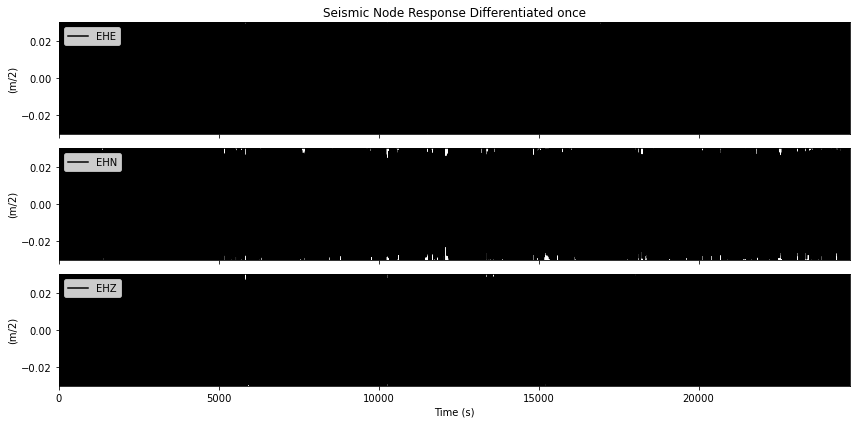

In [18]:
ymin, ymax = -0.03, 0.03

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].set_title("Seismic Node Response Differentiated once")
axes[0].plot(EHE.times()[:-1], np.diff(EHE.data, n=1), "k", label="EHE")
axes[0].set_ylabel("(m/2)")
axes[0].legend(loc=2)
axes[0].set_ylim(ymin, ymax)

axes[1].plot(EHN.times()[:-1], np.diff(EHN.data, n=1), "k", label="EHN")
axes[1].set_ylabel("(m/2)")
axes[1].legend(loc=2)
axes[1].set_ylim(ymin, ymax)

# axes[2].plot(EHN.times(), trace, "k", label=r"EHE$*$EHN")
axes[2].plot(EHZ.times()[:-1], np.diff(EHZ.data, n=1), "k", label="EHZ")
axes[2].set_ylabel("(m/2)")
axes[2].set_xlabel("Time (s)")
axes[2].legend(loc=2)
axes[2].set_xlim(tmin, tmax)
axes[2].set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig('./fig/nodal_diff.png')
plt.show()
plt.close('all')

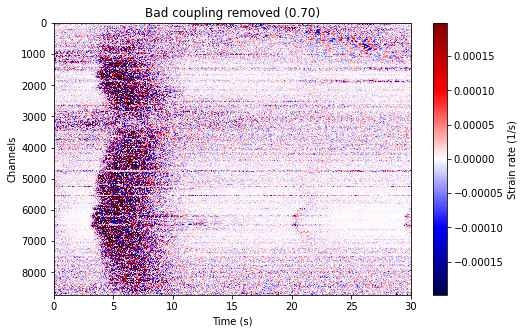

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(only_good, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title(f"Bad coupling removed ({thresh:.2f})")
plt.savefig(f"./fig/bad_removed_{thresh:.2f}.png")
plt.show()

In [ ]:
def nodal_pearsonr(brady_data, trace_E, trace_N, n=10):
    nodal_spearmanr = np.zeros((brady_data.shape[0]))

    for i in range(brady_data.shape[0]):
        DAS_spec = np.abs(np.fft.rfft(brady_data[i,:]))
        trace_E_spec = np.abs(np.fft.rfft(trace_E.data))
        trace_N_spec = np.abs(np.fft.rfft(trace_N.data))
        
        spec = np.vstack((bn.partition(DAS_spec, n)[:n], bn.partition(trace_E_spec, n)[:n], bn.partition(trace_N_spec, n)[:n]))
        nodal_spearmanr[i] = np.nanmedian(np.abs(stats.spearmanr(spec, axis=1)[0][0,1:3]))

    return nodal_spearmanr

In [ ]:
nodal_r = nodal_pearsonr(brady_data, np.diff(EHE, n=2), np.diff(EHN, n=2))

MemoryError: 

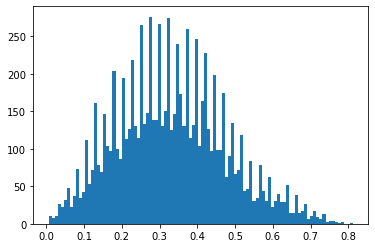

In [ ]:
plt.hist(nodal_r,bins=100)
plt.show()

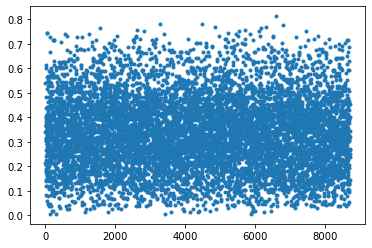

In [ ]:
plt.plot(nodal_r, '.')

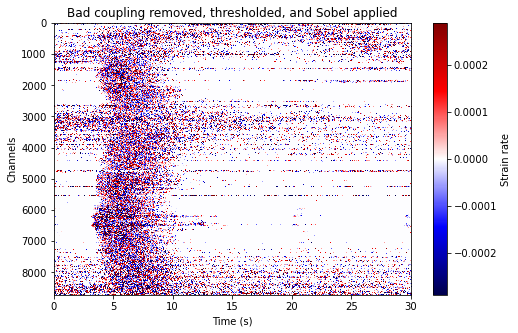

In [18]:
thresh = 0.00005

clipped = only_good.copy()
clipped[np.logical_and(only_good < thresh, only_good > -thresh)] = 0
sobel = ndimage.sobel(clipped, 1)

fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(sobel, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title(f"Bad coupling removed, thresholded, and Sobel applied")
plt.show()

plt.close('all')

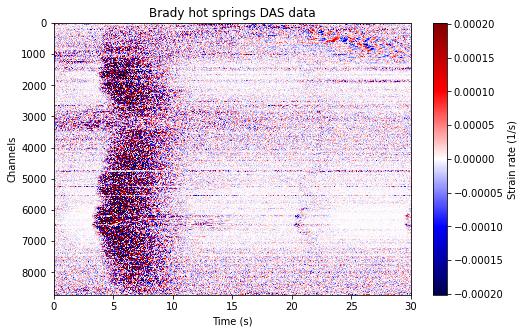

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(brady_data, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title("Brady hot springs DAS data")
plt.savefig(f"./fig/raw.png")
plt.show()

In [21]:
plt.close('all')

In [22]:
del brady_data, timestamps, pearsonr, EHE, EHN, EHZ, only_good, bad, thresh, sobel

NameError: name 'sobel' is not defined

In [23]:
foresee_data, props, distances = loadtdms(foresee_path)
extent = [0, foresee_data.shape[1]//500, distances[-1], distances[0]]

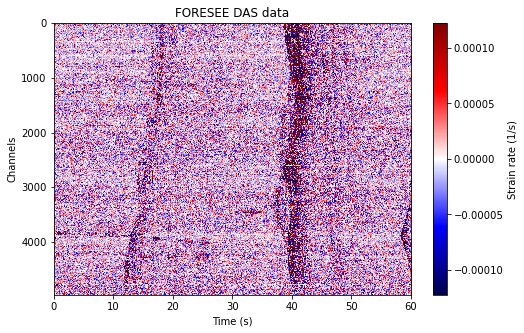

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(foresee_data, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title("FORESEE DAS data")
plt.savefig(f"./fig/FORESEE_raw.png")
plt.show()
plt.close('all')

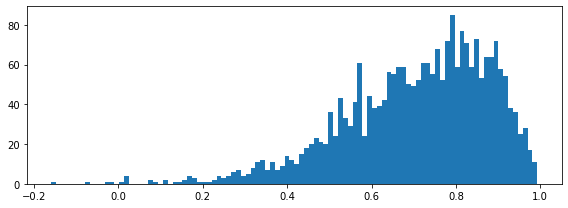

<Figure size 432x288 with 0 Axes>

In [25]:
pearsonr = pearson(foresee_data, buf)

plt.figure(figsize=(8,3))
plt.hist(pearsonr, bins=100)

plt.tight_layout()
plt.show()
plt.savefig(f"./fig/FORESEE_histogram.png")

In [26]:
bad, thresh = find_bad(pearsonr, 0.5)
only_good = np.delete(foresee_data, bad, axis=1)
print(f"{bad.size} bad channels removed (threshold value = {thresh:.2f})")

291 bad channels removed (threshold value = 0.50)


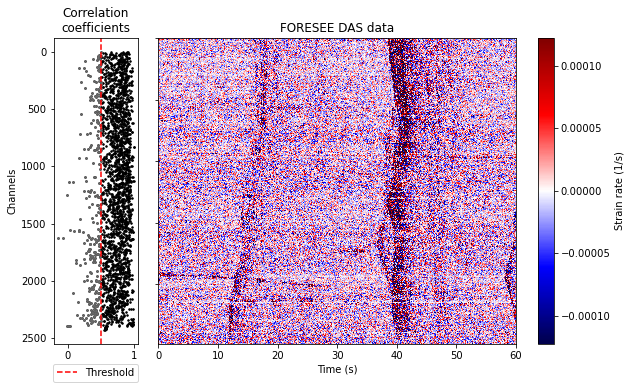

In [27]:
fig = plt.figure(figsize=(9, 5.5))

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1.5, 8])

ax2 = fig.add_subplot(spec[0])
ax2.plot(pearsonr, np.arange(0, foresee_data.shape[0]-buf), 'k.', markersize=3)
ax2.plot(pearsonr[bad], bad, color='dimgray', marker='.', markersize=3)
ax2.axvline(thresh, color='red', linestyle='dashed')
ax2.set_title("Correlation\ncoefficients")
ax2.set_ylabel("Channels")
plt.gca().invert_yaxis()

ax = fig.add_subplot(spec[1])
basicSeismicPlotter(foresee_data, extent=extent)
ax.set_yticklabels([])
ax.set_xlabel("Time (s)")
ax.set_title("FORESEE DAS data")

ax2.legend(handles=[Line2D([0], [0], color='red', linestyle='--', label='Threshold')],
          loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True)

plt.tight_layout()
plt.savefig("./fig/foresee_correlation_subplot.png")
plt.show()
plt.close('all')

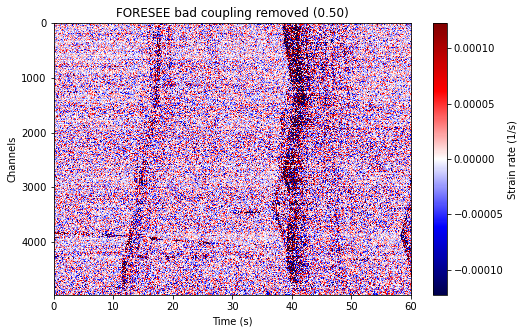

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(only_good, extent=[0, foresee_data.shape[1]//500, distances[-1], distances[0]])
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title(f"FORESEE bad coupling removed ({thresh:.2f})")
plt.savefig(f"./fig/foresee_bad_removed_{thresh:.2f}.png")
plt.show()

In [29]:
foresee_path

'data\\PSUDAS_UTC_20190415_033335.812.tdms'

In [30]:
foresee_path = r'C:\Users\kimki\Dropbox\DAScompression\data\apr-271\apr\PSUDAS_UTC_20190415_031835.812.tdms'
foresee_data, props, distances = loadtdms(foresee_path)
extent = [0, foresee_data.shape[1]//500, distances[-1], distances[0]]

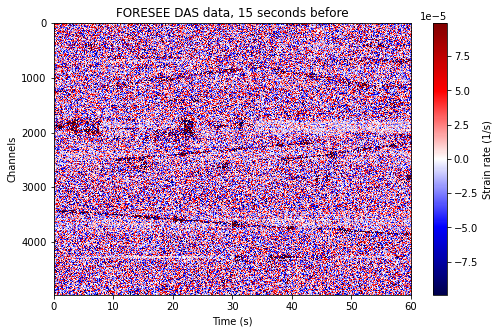

In [31]:
# 15 seconds before the last dataset used

fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(foresee_data, extent=extent)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title("FORESEE DAS data, 15 seconds before")
plt.savefig(f"./fig/FORESEE2_raw.png")
plt.show()
plt.close('all')

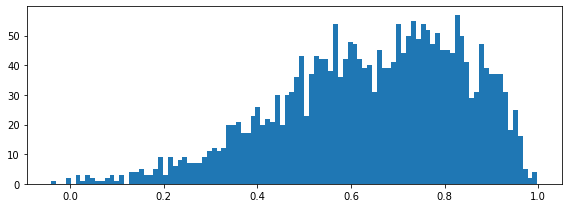

In [32]:
pearsonr = pearson(foresee_data, buf)

plt.figure(figsize=(8,3))
plt.hist(pearsonr, bins=100)

plt.tight_layout()
plt.savefig(f"./fig/FORESEE2_histogram.png")
plt.show()

In [33]:
bad2, thresh = find_bad(pearsonr, 0.3)
only_good = np.delete(foresee_data, bad, axis=1)
print(f"{bad2.size} bad channels removed (threshold value = {thresh:.2f})")

130 bad channels removed (threshold value = 0.30)


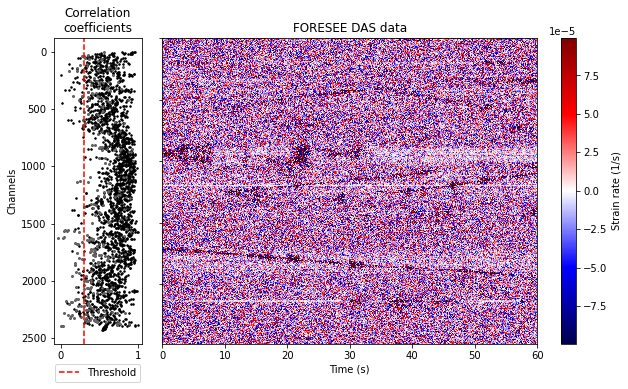

In [34]:
fig = plt.figure(figsize=(9, 5.5))

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1.5, 8])

ax2 = fig.add_subplot(spec[0])
ax2.plot(pearsonr, np.arange(0, foresee_data.shape[0]-buf), 'k.', markersize=3)
ax2.plot(pearsonr[bad], bad, color='dimgray', marker='.', markersize=3)
ax2.axvline(thresh, color='red', linestyle='dashed')
ax2.set_title("Correlation\ncoefficients")
ax2.set_ylabel("Channels")
plt.gca().invert_yaxis()

ax = fig.add_subplot(spec[1])
basicSeismicPlotter(foresee_data, extent=extent)
ax.set_yticklabels([])
ax.set_xlabel("Time (s)")
ax.set_title("FORESEE DAS data")

ax2.legend(handles=[Line2D([0], [0], color='red', linestyle='--', label='Threshold')],
          loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True)

plt.tight_layout()
plt.savefig("./fig/foresee2_correlation_subplot.png")
plt.show()
plt.close('all')

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
basicSeismicPlotter(only_good, extent=[0, foresee_data.shape[1]//500, distances[-1], distances[0]])
ax.set_xlabel("Time (s)"); ax.set_ylabel("Channels")
ax.set_title(f"FORESEE bad coupling removed ({thresh:.2f})")
plt.savefig(f"./fig/foresee2_bad_removed_{thresh:.2f}.png")
plt.show()

In [ ]:
# automated!!
# how long would it take for a person to do this? how many manholes and everything?